# USER DATA ANALYSIS #


## Molly Gibson ## 
### December 10, 2017 ###

In [1]:
import pandas as pd
import numpy as np

# load the data into dataframes:
requests = pd.read_csv('thread_requests.csv')

requests.head()


,thread_request_id,user_id,message_thread_id,time_estimate,started_at,category,category_name
0,346428,3027,202964,300,2016-12-22 23:37:37.290278,1.0,remember
1,346743,1091,204007,900,2016-12-23 16:39:11.012272,1.0,remember
2,347547,2568,204453,300,2016-12-26 01:30:43.645915,1.0,remember
3,347882,1304,204645,900,2016-12-27 02:50:02.940321,10.0,find_answer
4,348714,213,205092,300,2016-12-29 00:56:49.136263,2.0,message


In [2]:
# and load the second dataset: 
states = pd.read_csv('thread_states.csv')

states.head()

,message_thread_id,thread_request_id,case,agent_id,lock_start,lock_end
0,169351,346261,queue,2494.0,2016-12-22 18:06:55.588717,2016-12-22 18:10:01.818545
1,203738,346275,lock,238.0,2016-12-22 18:32:31.106625,2016-12-22 18:34:16.399532
2,203738,346275,done,238.0,2016-12-22 18:34:16.399532,NaN
3,202512,346235,done,2527.0,2016-12-22 18:41:24.91635,2016-12-22 18:41:28.919264
4,203670,346231,lock,238.0,2016-12-22 18:52:17.89301,2016-12-22 18:55:24.746147


In [3]:
# my own module that neatly describes a dataframe
from column_report import get_column_report

print('THREAD REQUESTS\n\nNumber of rows: %s ' % len(requests))
get_column_report(requests)

THREAD REQUESTS

Number of rows: 72058 


,Column Name,Data Type,Unique Count,Sample Value,NaNs,% NaN
0,thread_request_id,int64,72058,346428,0,0.00
1,user_id,int64,1020,3027,0,0.00
2,message_thread_id,int64,49146,202964,0,0.00
3,time_estimate,int64,42,300,0,0.00
4,started_at,object,72058,2016-12-22 23:37:37.290278,0,0.00
5,category,float64,19,1,84,0.12
6,category_name,object,19,remember,84,0.12


In [107]:
print('THREAD STATES\n\nNumber of rows: %s' % len(states))
get_column_report(states)

THREAD STATES

Number of rows: 404805


,Column Name,Data Type,Unique Count,Sample Value,NaNs,% NaN
0,message_thread_id,int64,62267,169351,0,0.00
1,thread_request_id,int64,109013,346261,0,0.00
2,case,object,4,queue,0,0.00
4,lock_start,object,404805,2016-12-22 18:06:55.588717,0,0.00
3,agent_id,float64,70,2494,20758,5.13
5,lock_end,object,342514,2016-12-22 18:10:01.818545,62095,15.34


In [5]:
# and now let's look at a few other things to get a better idea of the data we're working with
print('The four cases of thread states: ')

states.case.value_counts()

The four cases of thread states: 


done      132201
queue     129062
lock      127040
paused     16502
Name: case, dtype: int64

In [4]:
print('Thread categories: ')

requests.category_name.value_counts()[:-1]

Thread categories: 


remember                  19102
scheduling_over_email      9785
calendar                   6754
message                    6463
find_answer                5583
research                   4558
spam                       3596
admin                      3277
shopping                   3101
booking                    2579
quick_reservation          1989
conversation               1576
needs_clarification        1511
travel                     1025
recommendation              871
remember_transcription      201
reminder                      2
Name: category_name, dtype: int64

In [6]:
# there can be multiple thread requests on each thread
print('number of unique message thread ids: %s ' % len(states.message_thread_id.unique()))
print('number of unique thread request ids: %s ' % len(states.thread_request_id.unique()))


number of unique message thread ids: 62267 
number of unique thread request ids: 109013 


# Question 1: #
## What can you tell us about trends in thread requests over time?
* Are we spending more or less time locked on thread requests?
* Are thread requests getting harder or easier?
* Are we pausing more or less over time?



In [111]:
# so for the first part of the question, we're concerned with the lock_start and lock_end times
# let's quickly check the dtypes and then convert to datetime if necessary
# print(states.dtypes)

states['lock_start'] = pd.to_datetime(states.lock_start)

states['lock_end'] = pd.to_datetime(states.lock_end)
#states.lock_start.min()
requests['started_at'] = pd.to_datetime(requests.started_at)

# create a date column to easily group the threads by day
states['date'] = states.lock_start.apply(lambda x: x.date())
#states['date'] = pd.to_datetime(states.date)

# it's important to know the time frame over which we're looking
print('This dataset contains thread requests from %s to %s' % 
          (str(states.date.min()), str(states.date.max())))

#states['date'] = pd.to_datetime(states.date)


This dataset contains thread requests from 2016-12-22 to 2017-06-20


In [174]:
# let's make a column of the time elapsed during the thread lock
# and convert elapsed time to seconds:

# there are a couple cases where lock_end is NaN or happens before the start time, 
# so make sure we're dealing with that
states['elapsed_time'] = np.where(states.lock_end > states.lock_start, 
                                  pd.to_timedelta(states.lock_end - states.lock_start).astype('timedelta64[s]'), 0)


print('Mean request time: %s seconds' % round(states.elapsed_time.mean(), 2))
print('\nMax request time: %s seconds' % str(states.elapsed_time.max()))

# as a general note, I'm not sure what lock_start and lock_end mean when the thread status is 'done'
# but the longest elapsed_times are all for the 'done' case

states.sort_values('elapsed_time', ascending=False)[:5]


Mean request time: 43049.77 seconds

Max request time: 15447885.0 seconds


,message_thread_id,thread_request_id,case,agent_id,lock_start,lock_end,date,elapsed_time
10967,188992,346580,done,2526.0,2016-12-23 05:55:37.041381,2017-06-20 01:00:22.408532,2016-12-23,15447885.0
30046,207632,353288,done,2525.0,2017-01-06 18:21:59.837852,2017-06-01 13:52:34.076808,2017-01-06,12598234.0
22301,209419,356607,done,238.0,2017-01-12 17:35:10.207722,2017-06-05 22:56:28.957922,2017-01-12,12460878.0
37186,211113,359825,done,298.0,2017-01-18 17:21:56.417731,2017-06-10 16:01:19.240266,2017-01-18,12350362.0
72323,161232,365806,done,2527.0,2017-01-27 23:20:57.904957,2017-06-17 03:32:27.166955,2017-01-27,12111089.0


In [276]:
# to observe trends over time, let's make a plot of average time locked in thread requests by day 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go
import plotly.plotly as py

def make_plot(xx, yy, yax, titl):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    dates = mdates.date2num(list(xx))
    plt.plot_date(dates, yy, '-', label=yax)
    plt.title(titl, fontsize=20)
    plt.ylabel(yax, fontsize=15)
    plt.xticks(fontsize=13), plt.yticks(fontsize=13)
    plt.legend()


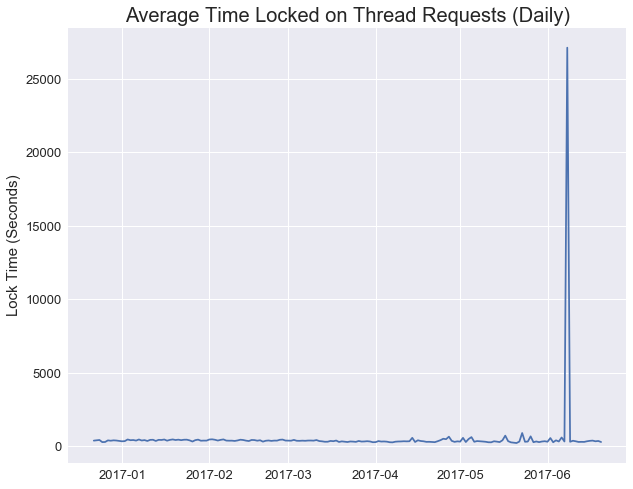

In [231]:
# check the average time locked in thread requests: (we are only concerned with 'locked' threads at the moment)
daily_means = states[states.case=='lock'].elapsed_time.groupby(states['date']).mean().reset_index()

#daily_means.head()

make_plot(daily_means['date'], daily_means['elapsed_time'], 'Lock Time (Seconds)', 
            'Average Time Locked on Thread Requests (Daily)')

 ## Hmmm.. what's going on with that spike on June 8th? There must be something funky happening... Let's take a closer look at the outlying elapsed_times. ##

In [114]:
# check out the longest periods of time threads were locked
longest_times = sorted(states[states['case']=='lock'].elapsed_time, reverse=True)[:20]

states[states['elapsed_time'].isin(longest_times)].sort_values('elapsed_time', ascending=False).head(10)
# as expected, other than one on 5/23, all of the longest times were on june 8th

,message_thread_id,thread_request_id,case,agent_id,lock_start,lock_end,date,elapsed_time
364064,255100,438281,lock,3811.0,2017-05-23 17:45:44.748568,2017-05-29 23:45:40.050188,2017-05-23,539995.0
398144,260505,447619,lock,NaN,2017-06-08 17:58:52.213965,2017-06-14 20:52:23.784236,2017-06-08,528811.0
357735,260498,447612,lock,NaN,2017-06-08 17:58:49.706270,2017-06-14 20:52:20.109197,2017-06-08,528810.0
403431,260499,447613,lock,NaN,2017-06-08 17:58:50.031653,2017-06-14 20:52:18.893889,2017-06-08,528808.0
386229,260500,447614,lock,NaN,2017-06-08 17:58:50.336518,2017-06-14 20:52:17.982943,2017-06-08,528807.0
369394,260484,447598,lock,NaN,2017-06-08 17:58:43.587279,2017-06-14 20:52:09.590698,2017-06-08,528806.0
401526,260501,447615,lock,NaN,2017-06-08 17:58:50.751936,2017-06-14 20:52:17.199177,2017-06-08,528806.0
377975,260503,447617,lock,NaN,2017-06-08 17:58:51.358076,2017-06-14 20:52:15.973197,2017-06-08,528804.0
377974,260486,447600,lock,NaN,2017-06-08 17:58:44.793042,2017-06-14 20:52:08.655692,2017-06-08,528803.0
401527,260504,447618,lock,NaN,2017-06-08 17:58:51.929603,2017-06-14 20:52:14.894867,2017-06-08,528802.0


## So, obviously there was some sort of hiccup on 06/08/17 that caused the thread lock times to be way longer than usual. It looks like the issue was resolved on 06/14. Let's take a closer look at June 8th.

In [115]:
# grab the 50 longest lock times on june 8th
june_8 = states[(states['date']==pd.Timestamp('2017-06-08')) & (states.case=='lock')] \
                            .sort_values('elapsed_time', ascending=False)[:50] 

# and see what's going on with those threads in the requests dataframe
requests[requests.message_thread_id.isin(june_8.message_thread_id)]


,thread_request_id,user_id,message_thread_id,time_estimate,started_at,category,category_name


## The unusually long elapsed_times on June 8th don't seem to have an agent connected with them (from the df snippet above). And the 50 threads with the longest elapsed_time on June 8 aren't in the thread requests dataset at all (empty df directly above). So there's some type of anomaly going on. In order to have our plot make more sense, let's remove the rows from 06/08 that have elapsed_time over 450000 (that seems to be a natural cutoff point)

In [186]:
print('Mean lock time on June 8th before removing anomalies: %.2f' % \
      states[(states.date==pd.Timestamp('2017-06-08')) & (states.case=='lock')]['elapsed_time'].mean())

print('Mean lock time on June 8th after removing anomalies: %.2f' % \
      states[(states.date==pd.Timestamp('2017-06-08')) & (states.case=='lock') & \
             (states.elapsed_time < 450000)]['elapsed_time'].mean())


Mean lock time on June 8th before removing anomalies: 27111.88
Mean lock time on June 8th after removing anomalies: 388.68


In [293]:
orglen = len(states)

states_ = states[~((states.date==pd.Timestamp('2017-06-08')) & (states.case=='lock') 
                   & (states.elapsed_time > 450000))].copy()

print('%s rows dropped' % (orglen - len(states_)))

54 rows dropped


In [148]:
# now let's redo the plot!

# check the average time locked in thread requests: (we are only concerned with 'locked' threads at the moment)
daily_means_ = states_[states_.case=='lock'].elapsed_time.groupby(states_['date']).mean().reset_index()
#daily_means.head()
data_ = [go.Scatter(x=daily_means_['date'], y=daily_means_['elapsed_time'])]

layout = go.Layout(
    yaxis=dict(title='Lock Time (seconds)'),
    title='Average Time Locked on Thread Requests (Daily)',
    showlegend = False)

fig = go.Figure(data=data_, layout=layout)

py.iplot(fig)

In [180]:

# check the sum of time locked in thread requests: (we are only concerned with 'locked' threads at the moment)
daily_sums = states_[states_.case=='lock'].elapsed_time.groupby(states_['date']).sum().reset_index()
#daily_means.head()
data_ = [go.Scatter(x=daily_sums['date'], y=daily_sums['elapsed_time'])]

layout = go.Layout(
    yaxis=dict(title='Lock Time (seconds)'),
    title='Sum of Time Locked on Thread Requests (Daily)',
    showlegend = False)

fig = go.Figure(data=data_, layout=layout)

py.iplot(fig)

# Nice! Those plots are a lot more meaningful that the first one. From the chart above, we can see the following trends in time locked on thread requests: 

## Slightly increasing at the end of 2016 and very beginning of 2017. January '17 stays relatively constant.
## From February 2017 to the middle of April '17, mean daily lock time is steadily trending downwards.  
## Starting mid-April, mean daily lock time becomes much more volatile. From this, we can infer that the thread requests are becoming more complicated as the team gets faster at completing them. To make sure that the team *is* becoming more efficient, let's check out the weekly averages/sums.

In [170]:

cpy = states_.copy().set_index('date')

weekly_means = cpy[['elapsed_time']].resample('W-MON').mean().reset_index()

wdata = [go.Scatter(x=weekly_means['date'], y=weekly_means['elapsed_time'])]

wlayout = go.Layout(
    yaxis=dict(title='Lock Time (seconds)'),
    title='Average Time Locked on Thread Requests (Weekly)',
    showlegend = False)

fig = go.Figure(data=wdata, layout=wlayout)

py.iplot(fig)


In [182]:
cpy = states_.copy().set_index('date')

weekly_sums = cpy[['elapsed_time']].resample('W-MON').sum().reset_index()

data = [go.Scatter(x=weekly_sums['date'], y=weekly_sums['elapsed_time'])]

layout = go.Layout(
    yaxis=dict(title='Lock Time (seconds)'),
    title='Sum of Time Locked on Thread Requests (Weekly)',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

# From the weekly average lock times, we can look at changes over time in a more macro sense:
## The times were indeed steadily decreasing from February to mid-April. 
## Some factor in mid-April caused the time locked on thread requests to jump higher than they've been since before 2017. There was a spike on the week of April 17th, then they slightly recovered in the next couple weeks before mid-May when they jump higher still. My best guess is that some type of more complicated functionality was released in April, and thus some of the thread requests started taking much longer.
## In the week of May 22, the weekly time spent begins to decrease rapidly. The team must've figured out a way to handle the more complicated requests ! :)


# Now let's check out the time spent on 'pause'!
## The question asks if we're pausing more or less over time, which could mean a) number of pauses or b) aggregate time spent paused. To get the aggregate time, we simply repeat the steps taken above, but only where case='paused'. Let's do that first.

In [183]:

# check the sum of time paused during thread requests: (now we are only concerned with 'paused' threads)
daily_sums = states[states.case=='paused'].elapsed_time.groupby(states['date']).sum().reset_index()

data = [go.Scatter(x=daily_sums['date'], y=daily_sums['elapsed_time'])]

layout = go.Layout(
    yaxis=dict(title='Pause Time (seconds)'),
    title='Sum of Time Paused During Thread Requests (Daily)',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

In [185]:
# now check out the longest periods of time threads were paused; we'll want to remove the outliers again
# so we can have a more meaningful plot
longest_pauses = sorted(states[states['case']=='paused'].elapsed_time, reverse=True)[:20]

states[states['elapsed_time'].isin(longest_pauses)].sort_values('elapsed_time', ascending=False).head(10)

,message_thread_id,thread_request_id,case,agent_id,lock_start,lock_end,date,elapsed_time
297258,247461,424932,paused,2301.0,2017-05-03 19:57:14.203277,2017-06-09 22:46:25.466899,2017-05-03,3206951.0
363189,256185,440011,paused,2494.0,2017-05-25 23:45:03.498930,2017-06-09 22:44:43.553868,2017-05-25,1292380.0
361604,257705,442792,paused,3226.0,2017-06-02 02:08:52.576829,2017-06-09 22:45:05.265793,2017-06-02,678972.0
396527,261101,448611,paused,2527.0,2017-06-10 13:56:30.458359,2017-06-13 00:57:24.240980,2017-06-10,212453.0
379540,261212,448787,paused,2494.0,2017-06-10 21:33:47.414649,2017-06-13 00:57:24.065070,2017-06-10,185016.0
384648,261269,448867,paused,3226.0,2017-06-11 01:41:33.431135,2017-06-13 00:57:23.893756,2017-06-11,170150.0
373763,261035,448986,paused,2527.0,2017-06-11 14:13:14.810226,2017-06-13 00:57:23.712351,2017-06-11,125048.0
401825,261368,449039,paused,238.0,2017-06-11 17:02:30.441748,2017-06-13 00:57:23.513349,2017-06-11,114893.0
370563,259472,447409,paused,2526.0,2017-06-09 00:16:19.543510,2017-06-09 22:45:26.458602,2017-06-09,80946.0
393427,252327,447464,paused,2524.0,2017-06-09 02:46:35.521896,2017-06-09 22:40:06.645672,2017-06-09,71611.0


In [191]:
# so let's remove these outliers, using the same threshold as earlier: 450k
orglen = len(states)

states_droppause = states[~((states.case=='paused') & (states.elapsed_time > 450000))]

print('%s rows dropped' % (orglen - len(states_droppause)))

3 rows dropped


In [188]:
daily_sums = states_droppause[states_droppause.case=='paused'] \
                    .elapsed_time.groupby(states_droppause['date']).sum().reset_index()

data = [go.Scatter(x=daily_sums['date'], y=daily_sums['elapsed_time'])]

layout = go.Layout(
    yaxis=dict(title='Pause Time (seconds)'),
    title='Sum of Time Paused During Thread Requests (Daily)',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

## The spike in pause times on 06/09-06/12 corresponds with the period that had very long response times, which makes sense. The server could've gone down or some other large maintenance issue that stopped the normal flow of work, so the team put their requests on pause, thus delaying lock times.

## Otherwise, the sum of time spent paused seems to steadily increase from January '17 to the beginning of June. After the large spike, they start to decline again.

In [190]:
daily_pause_count = states_[states_.case=='paused'].elapsed_time.groupby(states_['date']).count().reset_index()

data = [go.Scatter(x=daily_pause_count['date'], y=daily_pause_count['elapsed_time'])]

layout = go.Layout(
    yaxis=dict(title='Number of Pauses (Daily)'),
    title='Number of Pauses During Thread Requests (Daily)',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

## When looking at the *number* of pauses, we also see a steady incline until June, when we start to see the number decreasing. This is consistent with the summed pause time plot above.

# Question 2:
## What can you tell us about our users?
### In order to look into user engagement, first we have to define it. In this context, one way to measure user engagement is by counting the number of users who make thread requests in a day (or week).  Let's start by doing a daily count of users who started requests.


In [192]:
print('Number of total users in the dataset: %s' % len(requests.user_id.unique()))

Number of total users in the dataset: 1020


In [285]:
# first we'll need to change the started_at column to datetime and then parse out the days so we can group by that
requests['date'] = pd.to_datetime(requests.started_at.apply(lambda x: x.date()))

# then let's count the number of requests each day and the number of unique users making requests
daily_active_users = requests[['date', 'user_id', 'thread_request_id']].groupby('date') \
                                        .agg({'thread_request_id': 'count','user_id': pd.Series.nunique}) \
                                        .reset_index() \
                                        .rename(columns={'thread_request_id':'num_requests', 'user_id': 'num_users'})
            
daily_active_users.head()

,date,num_requests,num_users
0,2016-12-22,154,66
1,2016-12-23,426,120
2,2016-12-24,265,91
3,2016-12-25,185,89
4,2016-12-26,221,101


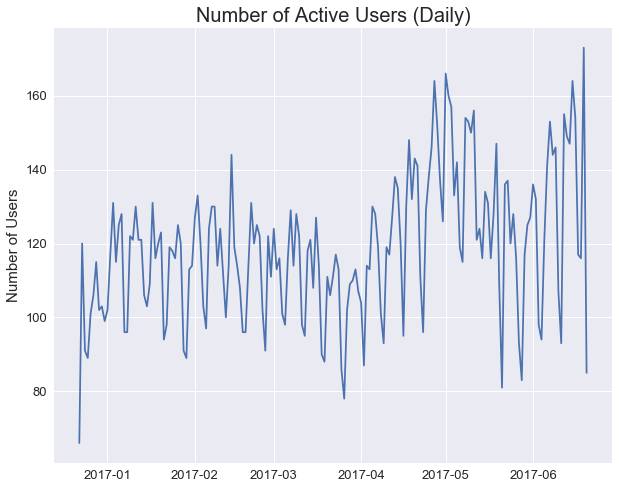

In [248]:
make_plot(daily_active_users['date'], daily_active_users['num_users'], 
          'Number of Users', 'Number of Active Users (Daily)')

## There's clearly an upward trend in daily active users over the given time period. In the past few months, the number of users making requests has been hovering around 150 per day.
## User engagement is, predictably, volatile on a daily basis, because there are lots of factors that would influence a user's need for Fin. Weekends most likely have less activity than weekdays. 

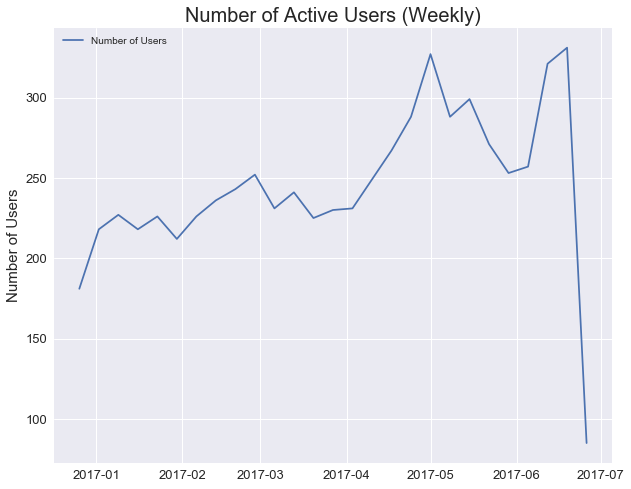

In [290]:
# Let's check out the number of active users on a weekly basis
# dau = daily_active_users.copy().set_index('date')

# #weekly_users = dau[['num_users', 'num_requests']].resample('W-MON').sum().reset_index()

wkly = requests.copy().set_index('date')

weekly_users = wkly[['user_id', 'thread_request_id']].resample('W-MON') \
                                        .agg({'thread_request_id': 'count','user_id': pd.Series.nunique}) \
                                        .reset_index()

make_plot(weekly_users['date'], weekly_users['user_id'], 'Number of Users', 'Number of Active Users (Weekly)')

#len(weekly_users['num_users'])

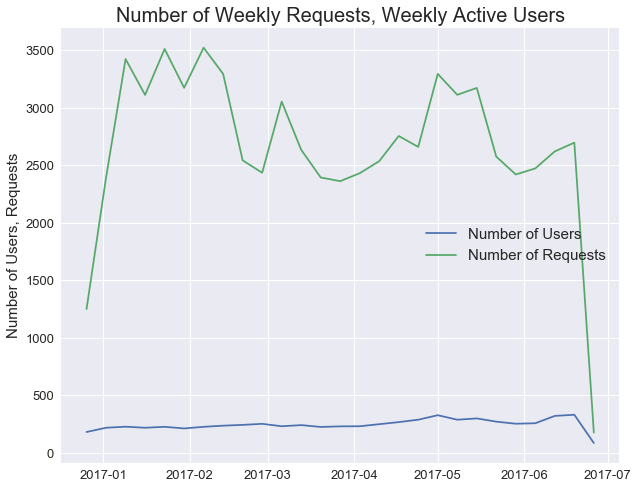

In [291]:
fig, ax = plt.subplots(figsize=(10, 8))
    
dates = mdates.date2num(list(weekly_users['date']))

plt.plot_date(dates, weekly_users['user_id'], '-', label='Number of Users')
plt.plot_date(dates, weekly_users['thread_request_id'], '-', label='Number of Requests')
plt.title('Number of Weekly Requests, Weekly Active Users', fontsize=20)
plt.ylabel('Number of Users, Requests', fontsize=15)
plt.xticks(fontsize=13), plt.yticks(fontsize=13)
plt.legend(fontsize=15)


In [295]:

weekly_users.tail()

,date,thread_request_id,user_id
22,2017-05-29,2421,253
23,2017-06-05,2474,257
24,2017-06-12,2622,321
25,2017-06-19,2698,331
26,2017-06-26,176,85


## Number of weekly users has been steadily increasing as well; it remains pretty steady as the number of requests jumps around. Both active users and requests have a dip in 06/17, which probably corresponds to the aforementioned event near the beginning of June. 
## We've been seeing around 300 engaged users on a weekly basis for the last month in the dataset. There's a sharp dropoff at the end of the plot, presumably because we don't have all of the days in the last week.

# Closing Remarks
## I was using plotly because I like the ability to scroll over the plots and see each individual day, but then I used up my plotly free trial and switched to matplotlib. Please excuse the inconsistency! 